# AffectNet data preparation

In this file we will prepare the AffectNet dataset for our model. We will clean, augment and split some data.

In [1]:
import os
import bz2
import cv2
import pickle
import numpy as np
import pandas as pd
from math import ceil
import _pickle as cPickle
from sklearn import model_selection
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import data_processing as dp
os.chdir(os.getcwd() + '/../')
import general_defenitions as gd

## Converting AffectNet to dataframe

### Extract tar files

The data set should be on [OneDrive](https://onedrive.live.com/?cid=3a9e5cb7d5cb0442&id=3A9E5CB7D5CB0442%2113336&authkey=!AElZ5UAlGVGCGdU) for the time being. Download it manually to your PC and go to step 1.2 If not, check the link to the download page of the author [here](https://onedrive.live.com/?authkey=%21AGUBDO3EDF%2DSws4&id=71A021B981CFE85B%21136507&cid=71A021B981CFE85B), download the dataset and proceed to step 1.1

Read the dataset and see what it contains. For our OnDrive version we will continue to discover only the dataset. For the data set of the author we first have to extract the .tar files. We will do that in the next step!

Extract the dataset. For this you have to comment out the code below and set the path where you want to get the extracted files.

In [2]:
# import sys
# # Set path where you want your files to be extracted.
# sys.path.append('C:/Users/storm/OneDrive/Documenten/HU/Jaar_2/BB8/test_data_lead')

# # Set path where your tar files are located.
# import tarfile
# my_tar = tarfile.open("C:/Users/storm/OneDrive/Documenten/HU/Jaar_2/BB8/test_data_lead/AffectNet-8Labels/val_set.tar", "r")
# my_tar.extractall()
# my_tar.close()

### Convert folders into dataframe

In [3]:
os.chdir(os.getcwd() + '/../../test_data_lead')

Let's define the numbers called in the files by what each number means.

In [4]:
emotions = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 
            7: 'Contempt', 8: 'None', 9: 'Uncertain', 10: 'No-Face'}

We create a new dataframe that we fill with all the images and targets.

In [5]:
df = pd.DataFrame(columns = ['formatted_pixels', 'target'])

Because of missing indexes in the file designations the index from the upcoming forloop and dataframe indexes won't run parralel. That's why we want de number of the last image so that we can count till that number in the for loop.


If you want to run this file yourself you probably have to change your path.

In [6]:
latest_img = dp.get_latest_index()

Number by number we fill the dataframe with numpy arrays of the pixels from an image with the corresponding emotion named target. Because the images indexes are not numbered consistently, we use a try and excpet to catch the ID errors. 


If you want to run this file yourself you probably have to change your path.

In [7]:
dp.convert_to_dataframe(latest_img, df, emotions, 'train_set')

Now that we have a compact frame we can throw away values that we don't want.

In [8]:
indexNames = df[df['target'] == 'Contempt'].index #7 staat voor contempt

df.drop(indexNames , inplace=True)

Set your own path where files are located using this path.

In [9]:
os.chdir(os.getcwd() + '/../EmpathicRobot/data/')

Save the dataframe as a pickle file. The pickle format is a fast and light way to save pandas dataframes. 

Meanwhile we save the dataframe of the AffectNet dataset. This way if we want to change something in the processing process we don't need to run the code that takes a long time to run.

In [10]:
filename = "datasets/affectNet_train_comp"
data = df

gd.comp_pickle_save(data, filename)

## Importing

Read the two compressed pkl files.

In [11]:
data = bz2.BZ2File('datasets/affectNet_train_comp', 'rb')
data = cPickle.load(data)

# test_data = bz2.BZ2File('datasets/affectNet_val_comp', 'rb')
# test_data = cPickle.load(test_data)

## 1. Data understanding

### 1.1 data exploration & analysis

Before we can start with the dataset, we need to know what it consists of. For this we will use analyzes and visualisations. This way we can gain a better understanding of our dataset.

The dataset therefore consists of a train and validation set.
Each has an annotations and images file.

In the annotations file we have the following for each image:

      "imageNum_lnd.npy": an array of the x, y coordinates and face width and height the x and y coordination are separated with a semi-column (;) and have the following structure:
     x1; y1; x2; y2 .... etc
     
      "imageNum_aro.npy": an arousal value of the expression in interval [-1, +1] for the ucertain and No-face categories the value would be -2
     
      "imageNum_val.npy": a valence value of the expression in interval [-1, + 1] for the ucertain and No-face categories the value would be -2
     
     "imageNum_exp.npy": the expression id of the face (0: Neutral, 1: Happiness, 2: Sadness, 3: Surprise, 4: Fear, 5: Disgust, 6: Anger, 7: Contempt, 8: None, 9 : Uncertain, 10: No-Face)
     
     
The images file only contains the photos in jpg format.

In [12]:
data.head()

,formatted_pixels,target
0,"[[[171, 149, 92], [176, 156, 97], [175, 155, 9...",Happiness
1,"[[[5, 1, 0], [5, 1, 0], [5, 1, 0], [5, 1, 0], ...",Neutral
2,"[[[234, 233, 238], [240, 240, 242], [245, 245,...",Neutral
3,"[[[144, 168, 92], [145, 169, 93], [147, 171, 9...",Happiness
4,"[[[13, 20, 26], [12, 19, 25], [13, 20, 26], [1...",Anger


In [13]:
placeHolder = data['target'].value_counts()
print(placeHolder)

Happiness    8967
Neutral      5090
Sadness      1728
Anger        1714
Surprise      999
Fear          398
Disgust       247
Name: target, dtype: int64


In [15]:
print('data:\n', pd.isnull(data).sum())

data:
 formatted_pixels    0
target              0
dtype: int64


## 2. Data preparation

The following function will make sure a numpy array gets filled with all images resized to 48x48x3.

In [16]:
X, y = dp.preprocess_data(data)

19143


We delete unnesecary columns and will normalize the data.

In [17]:
X, y = dp.clean_data_and_normalize(X, y)

Split all data in train, test and validation sets for our model.

In [18]:
x_train, y_train, x_val, y_val, x_test, y_test = gd.split_data(X, y)

(19143, 48, 48, 3)
(19143,)


This function will show 25 processed images.

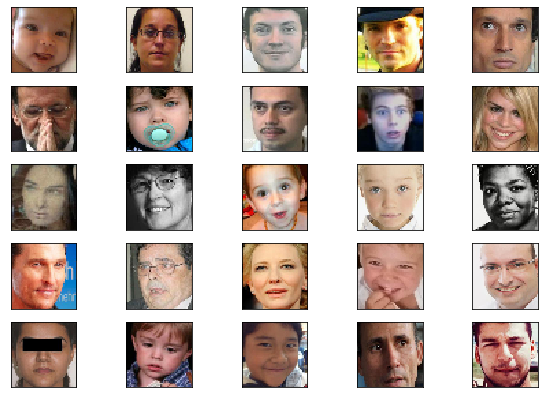

In [19]:
gd.show_images(x_train)

In [20]:
filename = "processed_sets/affectNet_processed"
data = [x_train, y_train, x_val, y_val, x_test, y_test]

gd.comp_pickle_save(data, filename)

## Data augmentation
By augmenting the data we want to achieve a higher accuracy on our model.

Data augmentation will rotate all images by 20 degrees and shift it by a fraction of the whole image. The function data_augmentation will also mirror the image.

In [21]:
datagen = gd.data_augmentation(x_train)

<class 'numpy.ndarray'>
(15313, 48, 48, 3)


The last function is going to show 25 of the images after augmenting.

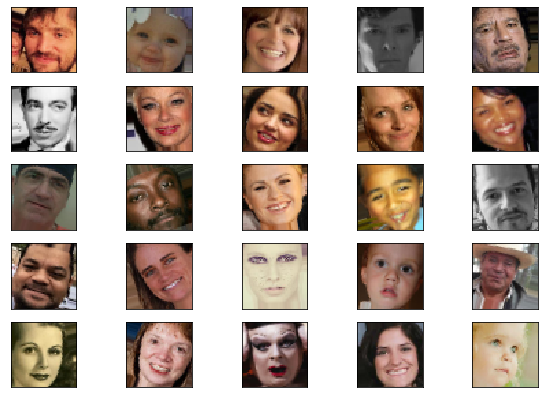

In [22]:
gd.show_augmented_images(datagen, x_train, y_train)

In [23]:
filename = "processed_sets/affectNet_augment"
data = [datagen, x_train, y_train, x_val, y_val, x_test, y_test]

gd.comp_pickle_save(data, filename)